In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from corner import corner
from tqdm import tqdm
from scipy.signal import tukey
from scipy.stats.distributions import norm
import kombine
import emcee
from multiprocessing import Pool
import time

import os
os.environ["OMP_NUM_THREADS"] = "1" #make sure numpy is using one thread
#leaving the samplers to work in parallel
import corner
from glitschen import *
plt.style.use(['dark_background'])

In [2]:
from glitschen import *

In [3]:
#by default training will use a 0.5s window, centered.
W, Z = train_ppca('./data/L1O3a_Tomtes_10-128.npy', plots=False, outtag=None, winlen=0.5)

In [4]:
testglitches = np.load('./data/L1O3a_tomtes_10-2048Hz_1.0s_test.npy')

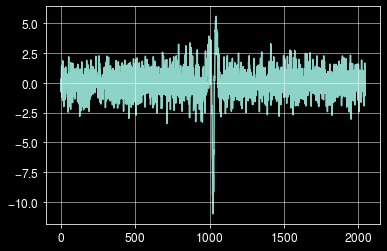

In [5]:
test = testglitches[10]
plt.plot(test)

## MaxL reconstruction

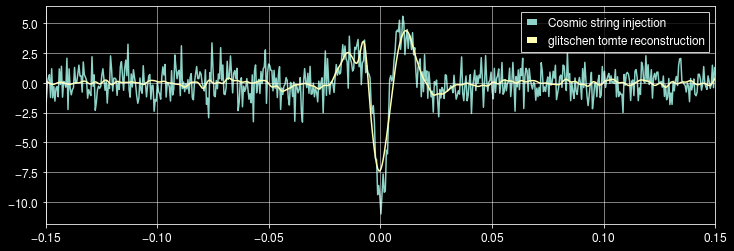

In [6]:
glitchrec = maxL_reconst(W, test, fixed=False, gfrac=0.1, metric='ip')

srate=2048
times = np.linspace(-len(test)/srate/2, len(test)/srate/2, int(len(test)))
glitchrects = TimeSeries(glitchrec, times=times)
plt.figure(figsize=(12,4))
plt.plot(times, test, label='Cosmic string injection')
plt.plot(times, glitchrects, label='glitschen tomte reconstruction') 
plt.xlim(-.15,.15)
plt.legend()

In [7]:
mf_snr(test, glitchrects)

<Quantity 33.61203911>

## Outlier_score
We can use the best reconstruction weights along with the training set to obtain a statistic, on [0,1] that tells us how likely an event is to be associated with a glitch type. The process is as follows: 

1. Train on only half of the training data.
2. Use the remaining half to obtain best reconstructions of known glitches.
3. Calculate the logpdf of these glitches and plot a histogram.
4. The fraction of training glitches with larger logpdfs than the run segment determines the outlier score.

This works better for larger sets of glitches.

outlier_score:  0.9616935483870968


0.9616935483870968

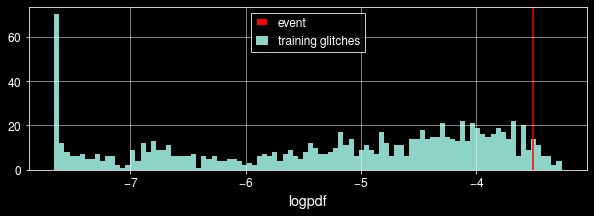

In [8]:
outlier_score('./data/L1O3a_Tomtes_10-128.npy', test)

In [14]:
seglen = 1.0
times = np.linspace(-0.5, 0.5, len(test))
ttest = TimeSeries(test, times=times)
trec = TimeSeries(maxL_reconst(W, test), times=times)
tres = ttest-trec
from matplotlib.ticker import FormatStrFormatter
q=8

/home/j/PycharmProjects/glitschen/venv/lib/python3.8/site-packages/gwpy/plot/plot.py:395: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = super().colorbar(mappable, **kwargs)


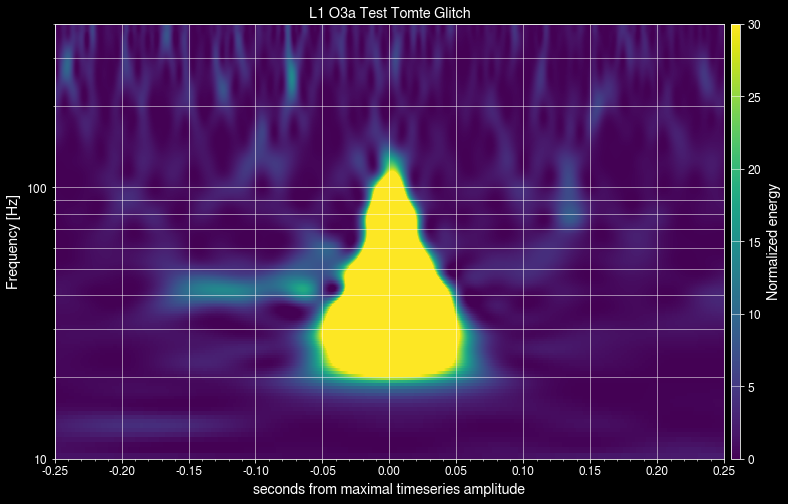

In [15]:
qs = ttest.q_transform(outseg=(-0.25,0.25), tres=0.0001, qrange=(q,q), 
                       frange=(10,400), whiten=False)
plot = qs.plot(figsize=[12,8])
ax = plot.gca()
ax.set_ylim(10,400)
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('seconds from maximal timeseries amplitude')
ax.grid(True, axis='y', which='both')
ax.set_title('L1 O3a Test Tomte Glitch')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plot.add_colorbar(cmap='viridis', label='Normalized energy',vmax=30, vmin=0)
plt.savefig('l1tomte.png')

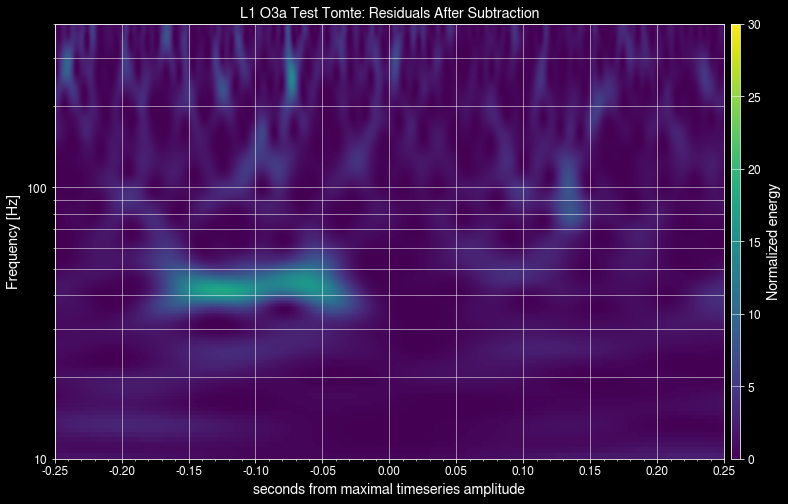

In [16]:
qs = tres.q_transform(outseg=(-0.25,0.25), tres=0.0001, qrange=(q,q), 
                       frange=(10,400), whiten=False)
plot = qs.plot(figsize=[12,8])
ax = plot.gca()
ax.set_ylim(10,400)
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('seconds from maximal timeseries amplitude')
ax.grid(True, axis='y', which='both')
ax.set_title('L1 O3a Test Tomte: Residuals After Subtraction')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plot.add_colorbar(cmap='viridis', label='Normalized energy', vmax=30, vmin=0)
plt.savefig('l1tomteres.png')

In [ ]:
#can use this code to make a blink gif.
from PIL import Image
frames = []
imgs = ['l1tomte.png', 'l1tomteres.png']
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
frames[0].save('blink_l1testtomte.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1000, loop=0)

## Sampler
In many cases, sampling gives us a much more powerful result than a point reconstruction.

In [10]:
# kde, 256 walkers, kombine, N=1000
test_fd = np.fft.rfft(test)
kdeprior = kombine.clustered_kde.optimized_kde(Z[:-1].T)
post = Posterior(test_fd, W, 2048, prior=kdeprior)


In [11]:
q=5
nwalkers=256
N=1000
p0 = initializer(nwalkers, timescale=0.2)

In [12]:
sampler = kombine.Sampler(nwalkers, q+1, post)

In [13]:
sampler.run_mcmc(N=N, p0=p0, update_interval=100)

(array([[ 2.79157561e-04,  9.67736658e-02, -4.75567566e-01,
          4.64644281e-01,  3.57268783e-01,  2.08154076e-01],
        [ 2.76576420e-04,  1.46107423e-01, -6.97091267e-01,
          2.05577716e-01,  7.50943018e-03,  5.27300693e-01],
        [ 7.61965427e-05,  7.56013571e-02, -5.29579474e-01,
          6.85453969e-01,  2.50737170e-02,  1.67586855e-01],
        ...,
        [-6.88172576e-06,  1.98606008e-01, -2.90928331e-02,
          3.98799499e-01, -1.61523003e-01,  4.24451661e-01],
        [ 2.78343772e-04,  8.48221374e-02, -4.94672981e-01,
          1.48120688e-01,  2.14139447e-01,  8.80551227e-02],
        [ 1.51841304e-04,  1.93556224e-01, -3.16320939e-01,
          9.55331087e-02, -2.63527520e-01,  5.85443226e-01]]),
 array([-1093.75662952, -1093.70652327, -1096.35243074, ...,
        -1095.62502032, -1092.70743063, -1094.39882265]),
 array([10.34202781, 10.06520117,  8.20427157, ...,  7.30798123,
        10.72133109, 10.00533113]))

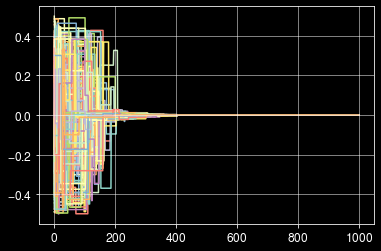

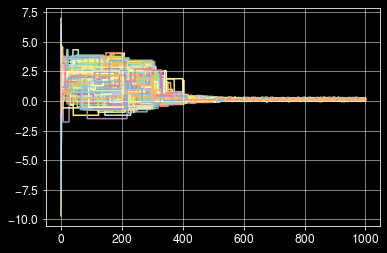

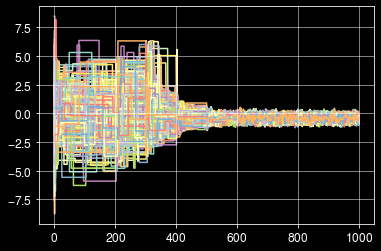

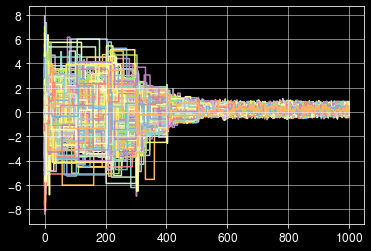

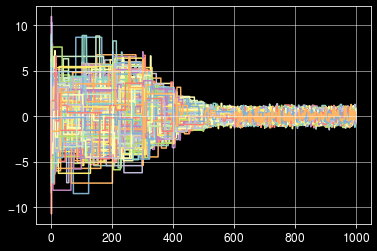

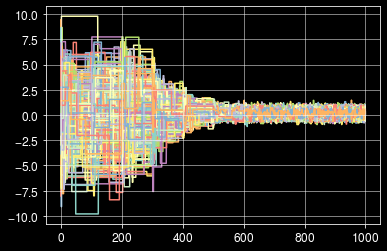

In [14]:
for i in range(0,q+1):
    plt.figure()
    plt.plot(sampler.chain[:,:,i])

In [23]:
samps=sampler.get_samples()

In [24]:
np.save('./data/L1O3a_test_tomte_10_samples.npy', samps)

In [25]:
#samps = np.load('./data/L1O3a_test_tomte_10_samples.npy')

In [27]:
samps.shape
#samps = samps[::5]

thinsamps = samps#[::100] optional thinning
thinsamps.shape

(8017, 6)

In [28]:
#builds the timeseries reconstructions from the samples
reconst_td = build_reconstructions(W, thinsamps, post)
logls = gen_logls(samps, post)
snrs = gen_snrs(samps, post)

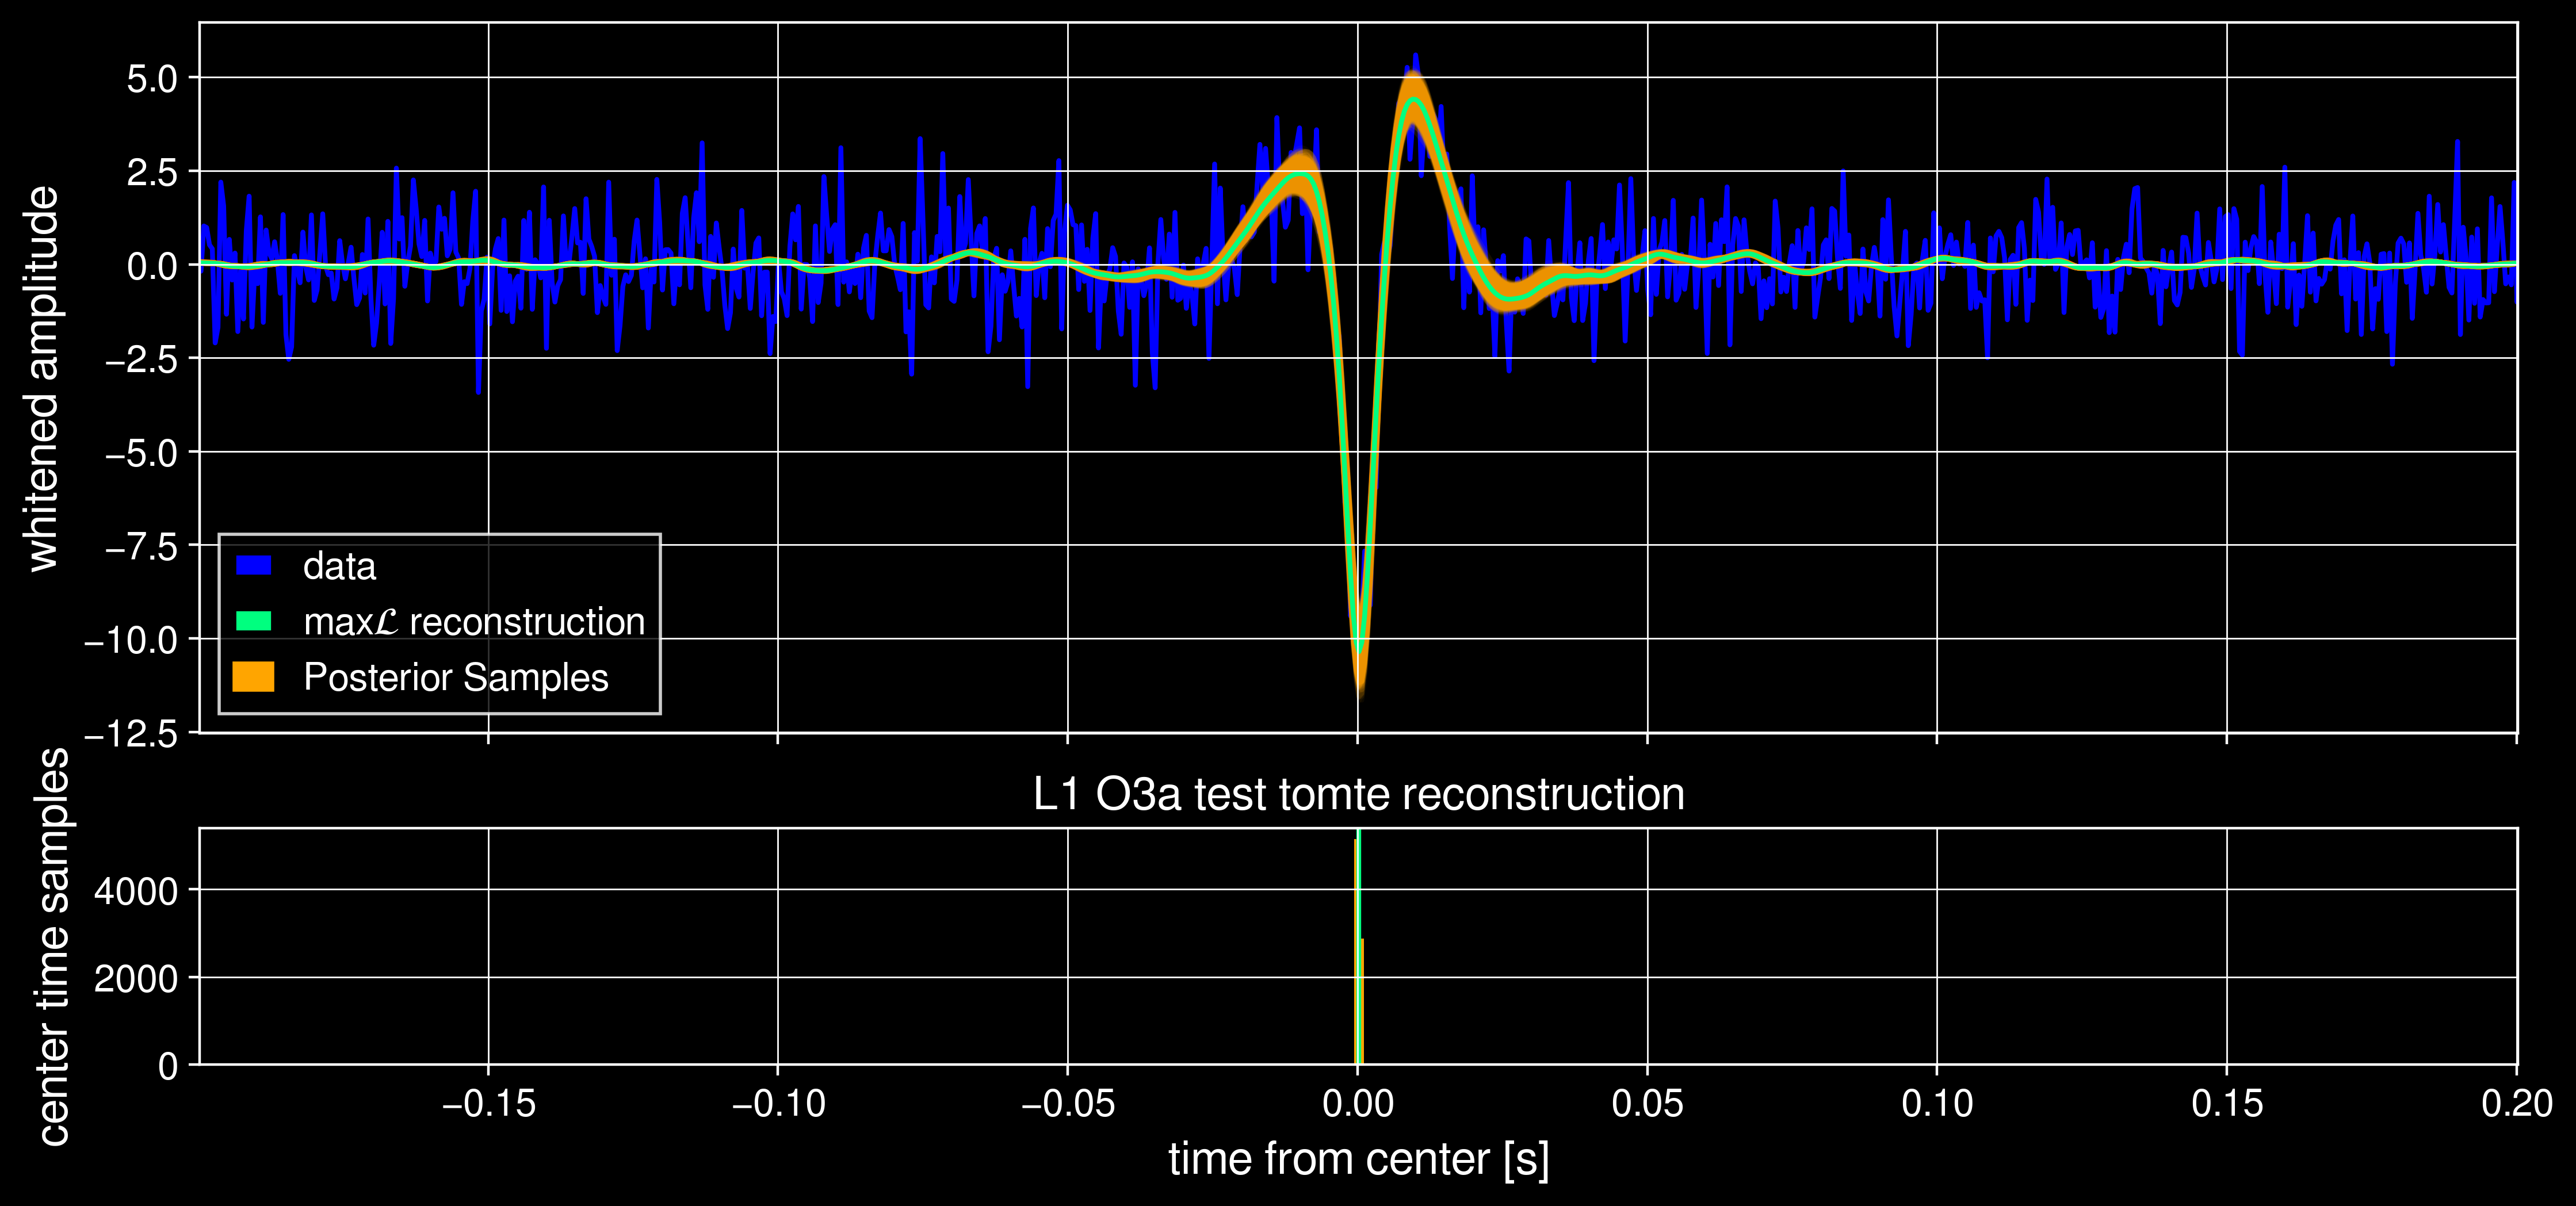

In [29]:
tcent = maxL_tcent(W, test)

plot_sampler_result(W, test, reconst_td, samps, xlim1=tcent-0.2, xlim2=tcent+0.2, title="L1 O3a test tomte reconstruction")

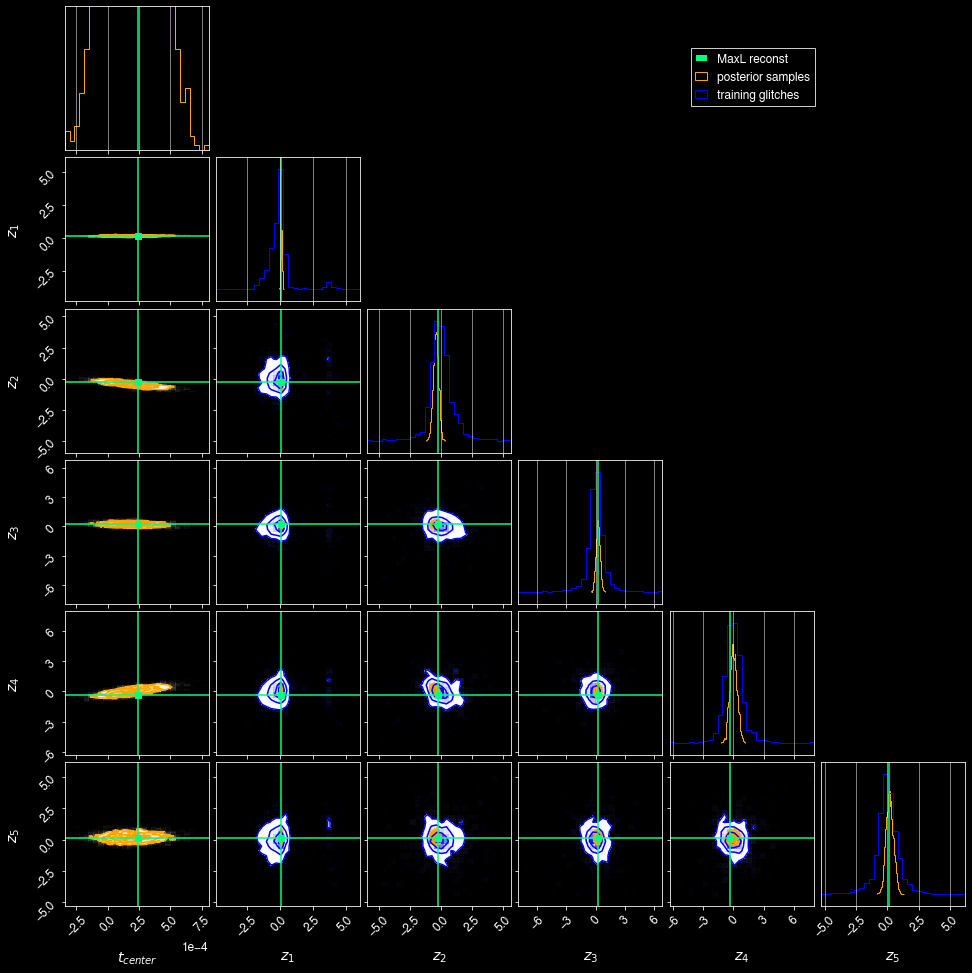

In [30]:
plot_corner_sample(Z, samps[::2], W, test, t_ylim=30)

/tmp/ipykernel_7251/4181969579.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=39, azim=50)


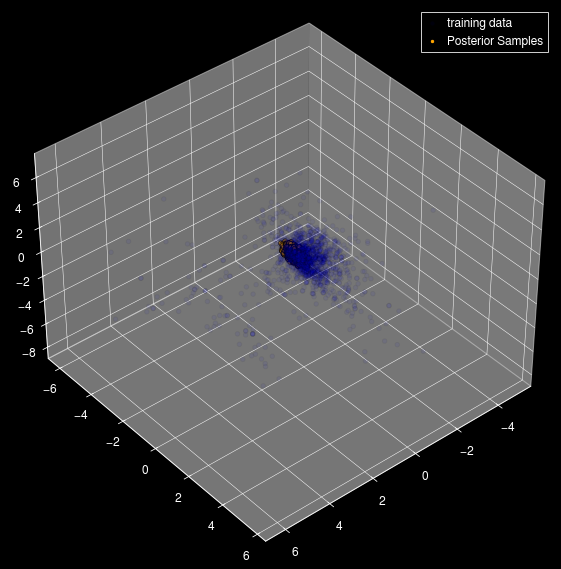

In [42]:
    fig = plt.figure(1, figsize=(8, 8))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=39, azim=50)
    ax.scatter(Z.T[:, 0], Z.T[:, 1], Z.T[:, 2], cmap=plt.cm.nipy_spectral,
               edgecolor='k', label='training data', alpha=0.05, color='blue')
    ax.scatter(thinsamps[:, 1], thinsamps[:, 2], thinsamps[:, 3], cmap=plt.cm.nipy_spectral,
               edgecolor='k', label='Posterior Samples', color='orange')
    ax.legend()

In [32]:
dic(logls)

2187.8742519336993

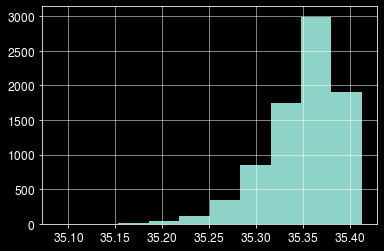

In [33]:
plt.hist(snrs);